In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as tfKeras

In [ ]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

**Loading the Data**


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataSets/data.zip")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking the shape of data

In [ ]:
df.shape

(284807, 31)

Checking any empty value

In [ ]:
df.isnull().values.any()

False

Presenting the DATA destribution

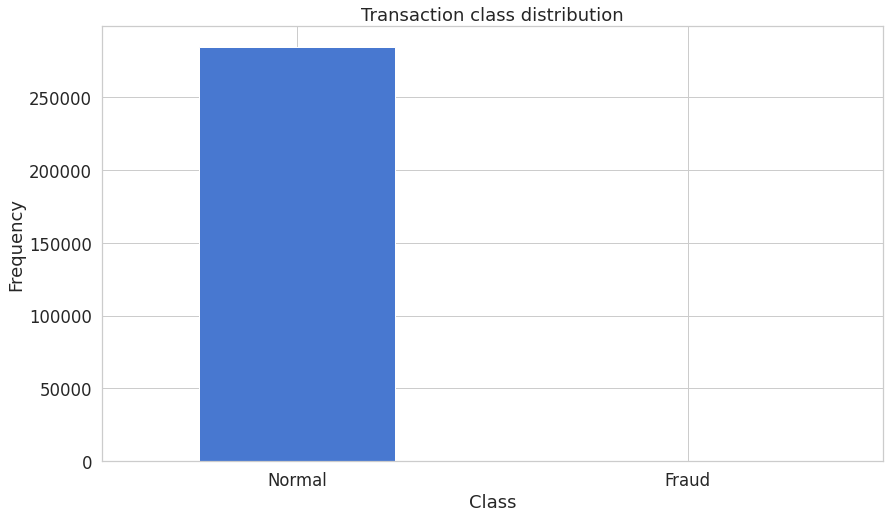

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

Filtering the data by class

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

Getting the shape of data

In [ ]:
print(normal.shape, frauds.shape)

(284315, 31) (492, 31)


Checking the data amount destribution

In [ ]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Plotting the destribution of data

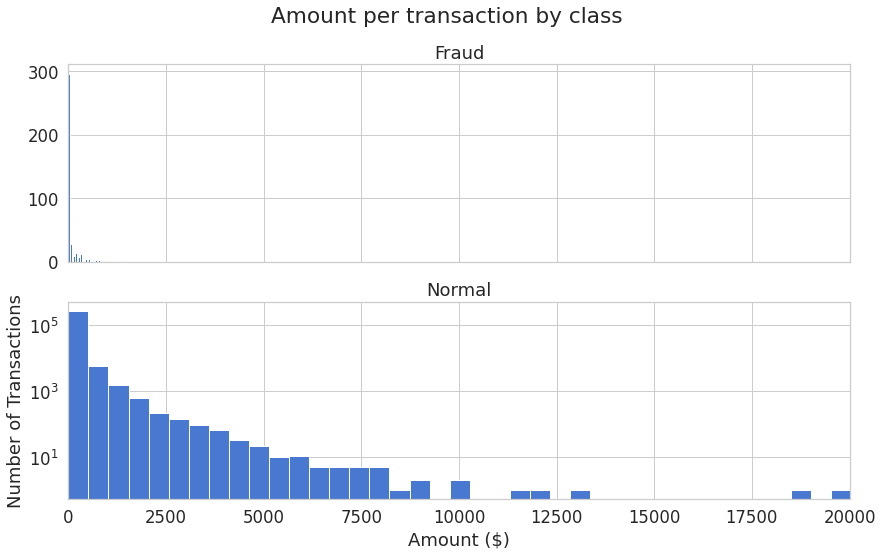

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

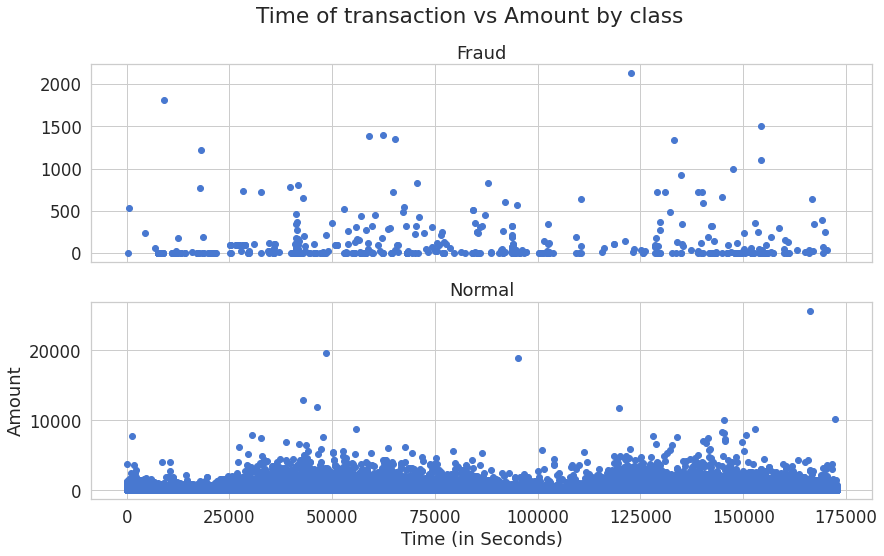

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Now lets remove the column Time (it's not relevant this time) use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to uniform the data

In [ ]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

Creating our dataset to train and test our model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.iloc[: , :-1], data['Class'], test_size=0.2, )

In [ ]:
input_dim = x_train.shape[1]
input_dim0 = x_train.shape[0]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding_dim * 6), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dropout(.3, input_shape=x_train.shape)(encoder)
encoder = Flatten()(encoder)
encoder = Dense(int(encoding_dim * 3),activation="relu")(encoder)
decoder = Dense(int(encoding_dim * 2),activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

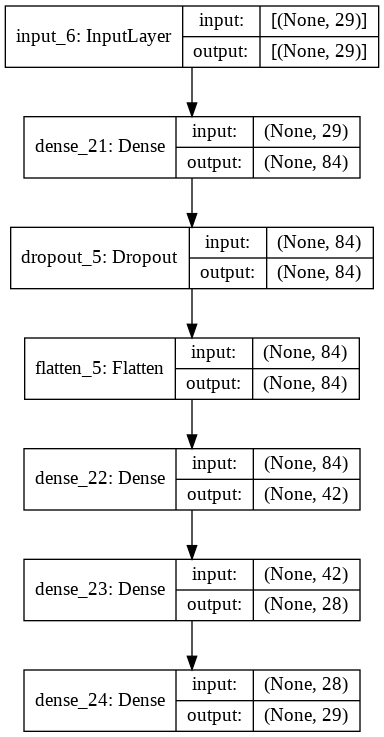

In [ ]:
tfKeras.utils.plot_model(autoencoder, 'model_image_classification_shapes.png', show_shapes=True)

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/DataSets/model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/DataSets/media/old-tf-hackers-7/logs',
histogram_freq=0,write_graph=True,write_images=True)
history = autoencoder.fit(x_train, x_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_data=(x_test, y_test),verbose=1,callbacks=[checkpointer,tensorboard]).history

Epoch 1/100
7121/7121 [==============================] - 30s 4ms/step - loss: 0.6980 - accuracy: 0.7488 - val_loss: 0.4338 - val_accuracy: 0.2390
Epoch 2/100
7121/7121 [==============================] - 31s 4ms/step - loss: 0.6534 - accuracy: 0.7946 - val_loss: 0.4402 - val_accuracy: 0.2442
Epoch 3/100
7121/7121 [==============================] - 28s 4ms/step - loss: 0.6470 - accuracy: 0.8013 - val_loss: 0.4410 - val_accuracy: 0.2197
Epoch 4/100
7121/7121 [==============================] - 29s 4ms/step - loss: 0.6438 - accuracy: 0.8042 - val_loss: 0.4582 - val_accuracy: 0.2273
Epoch 5/100
7121/7121 [==============================] - 28s 4ms/step - loss: 0.6411 - accuracy: 0.8069 - val_loss: 0.4461 - val_accuracy: 0.2448
Epoch 6/100
7121/7121 [==============================] - 29s 4ms/step - loss: 0.6406 - accuracy: 0.8082 - val_loss: 0.4549 - val_accuracy: 0.2249
Epoch 7/100
7121/7121 [==============================] - 31s 4ms/step - loss: 0.6388 - accuracy: 0.8098 - val_loss: 0.4717 -

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/DataSets/model.h5')

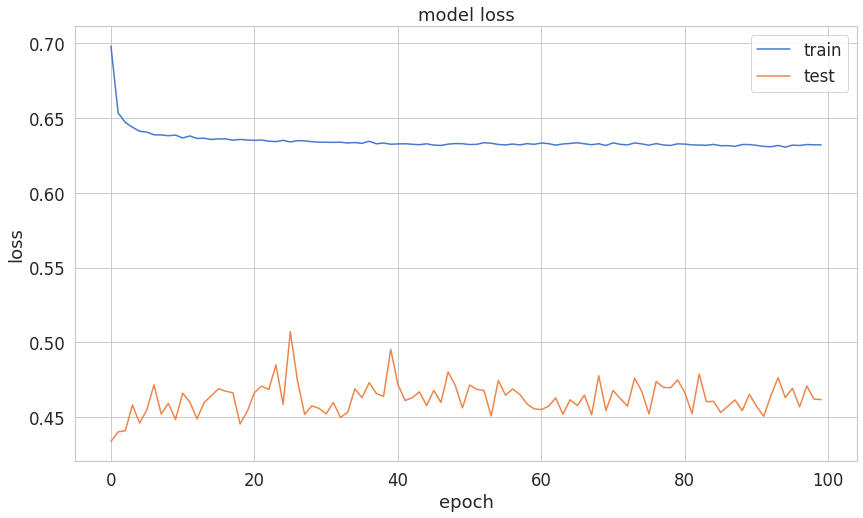

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

L'erreur de reconstruction sur nos données d'entraînement et de test semble bien
converger. Est-il assez bas? Examinons de plus près la distribution des erreurs:


In [ ]:
predictions = autoencoder.predict(x_test)

In [ ]:
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

In [ ]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.606968,0.001633
std,2.952684,0.040374
min,0.020547,0.000000
25%,0.177449,0.000000
50%,0.298811,0.000000
75%,0.502134,0.000000
max,170.969592,1.000000


Erreur de reconstruction sans fraude

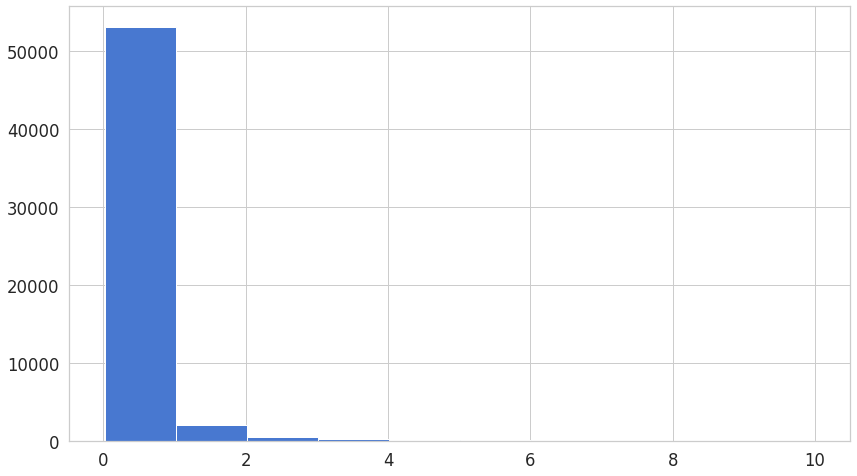

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) &
(error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

Erreur de reconstruction avec fraude

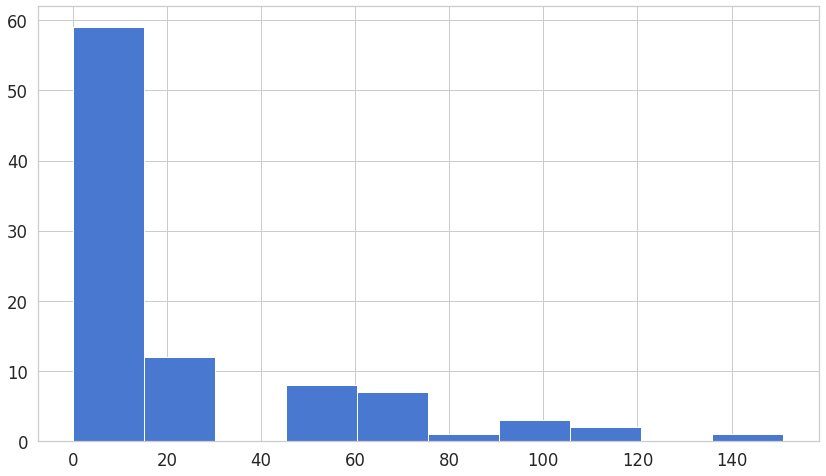

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

Les courbes ROC sont un outil très utile pour comprendre les performances des
classificateurs binaires. Cependant, notre cas sort un peu de l'ordinaire. Nous avons un
ensemble de données très déséquilibré. Néanmoins, jetons un œil à notre courbe ROC:

In [ ]:
from sklearn.metrics import (confusion_matrix,precision_recall_curve, auc,roc_curve, recall_score,classification_report, f1_score,precision_recall_fscore_support)

In [ ]:
threshold = 2.9

Confusion Matrix 


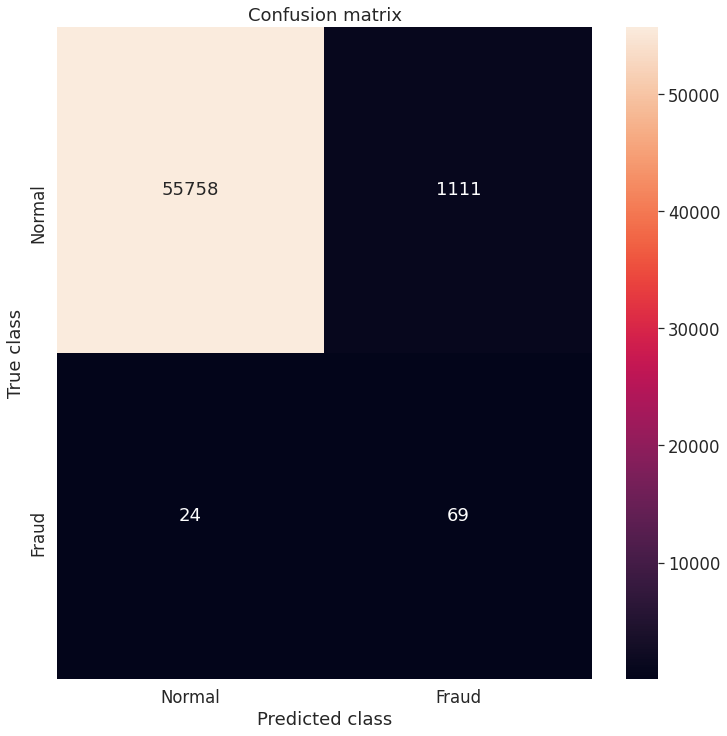

In [ ]:
y_pred = [1 if e > threshold else 0 for e in
error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS,
annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

So using our confusion matrix we can say about the accuracy:
Detecting Normal operations : 98%
Detecting Fraud operations: 65%